In [11]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [12]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [13]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [14]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [15]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [18]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [19]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.303711414337158
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0153, -0.0013, -0.0712,  0.0847,  0.1243, -0.0078,  0.0889, -0.0357,
         -0.1665,  0.1871],
        [-0.1204, -0.0026, -0.0474,  0.0753,  0.1640, -0.0596,  0.1064,  0.0017,
         -0.1061,  0.2330]])


In [20]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.323277473449707, 'val_acc': 0.10087890923023224}]

In [24]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2466, val_acc: 0.9232
Epoch [1], val_loss: 0.1747, val_acc: 0.9466
Epoch [2], val_loss: 0.1555, val_acc: 0.9547
Epoch [3], val_loss: 0.1495, val_acc: 0.9564
Epoch [4], val_loss: 0.1461, val_acc: 0.9591
Epoch [5], val_loss: 0.1511, val_acc: 0.9557
Epoch [6], val_loss: 0.1302, val_acc: 0.9640
Epoch [7], val_loss: 0.1628, val_acc: 0.9533
Epoch [8], val_loss: 0.1384, val_acc: 0.9592
Epoch [9], val_loss: 0.1327, val_acc: 0.9612


In [25]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [29]:
    def predict_image(img, model):
        xb = img.unsqueeze(0)
        yb = model(xb)
        _, preds  = torch.max(yb, dim=1)
        return preds[0].item()

In [33]:
torch.save(model.state_dict(), 'digit.pth')

Label: 2 , Predicted: 2


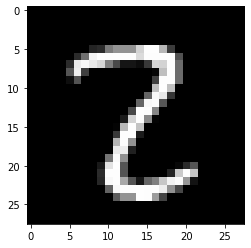

In [30]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [35]:
img, label = test_dataset[1839]
img.shape

torch.Size([1, 28, 28])

In [34]:
model.load_state_dict(torch.load('digit.pth'))
model.eval()

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)